In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime 

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

/Users/weishunji/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Read data 
d1 = pd.read_csv('40.77_-73.94_Yr_1.csv', skiprows = [0,1])
d2 = pd.read_csv('40.77_-73.94_Yr_2.csv', skiprows = [0,1])
d3 = pd.read_csv('40.77_-73.94_Yr_3.csv', skiprows = [0,1])
d4 = pd.read_csv('40.77_-73.94_Yr_4.csv', skiprows = [0,1])
d5 = pd.read_csv('40.77_-73.94_Yr_5.csv', skiprows = [0,1])

In [21]:
### Exploratory Data Analysis ###

# Define a function to compute the daily GHI
def daily_ghi(data, year):
    data['Day_of_the_Year'] = [(datetime(int(x[0]),int(x[1]),int(x[2])) - \
                                datetime(year,1,1)).days + 1 for x in data.values]
    ghi = data.groupby('Day_of_the_Year').sum()['GHI']
    del data['Day_of_the_Year']
    return list(ghi)

Daily_GHI = pd.DataFrame({'Year_1': daily_ghi(d1,1),
                          'Year_2': daily_ghi(d2,2),
                          'Year_3': daily_ghi(d3,3),
                          'Year_4': daily_ghi(d4,4),
                          'Year_5': daily_ghi(d5,5)})

# Data Summary
Daily_GHI.describe().round()

,Year_1,Year_2,Year_3,Year_4,Year_5
count,365.0,365.0,365.0,365.0,365.0
mean,8266.0,8280.0,8402.0,8521.0,8071.0
std,4458.0,4148.0,4400.0,4497.0,4316.0
min,818.0,773.0,540.0,280.0,273.0
25%,4618.0,5002.0,4713.0,5040.0,4525.0
50%,7714.0,7603.0,8073.0,8252.0,7542.0
75%,11760.0,11477.0,12206.0,12388.0,11684.0
max,17311.0,17355.0,17388.0,17613.0,16881.0


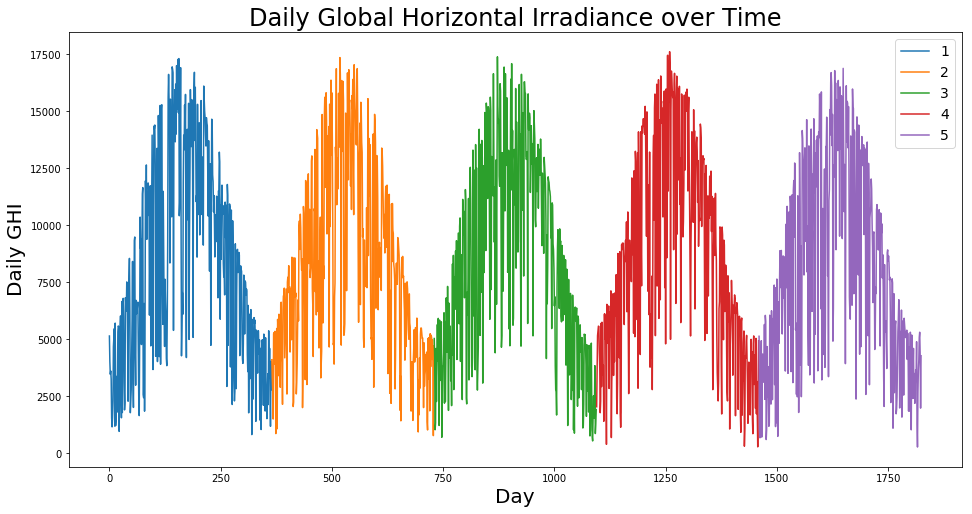

In [15]:
# Plot the daily GHI
time_point = [i*365 for i in range(6)]
plt.figure(figsize = (16,8))
plt.plot(range(time_point[0], time_point[1]), Daily_GHI['Year_1'], label = '1')
plt.plot(range(time_point[1], time_point[2]), Daily_GHI['Year_2'], label = '2')
plt.plot(range(time_point[2], time_point[3]), Daily_GHI['Year_3'], label = '3')
plt.plot(range(time_point[3], time_point[4]), Daily_GHI['Year_4'], label = '4')
plt.plot(range(time_point[4], time_point[5]), Daily_GHI['Year_5'], label = '5')
plt.title('Daily Global Horizontal Irradiance over Time', {'fontsize': 24})
plt.xlabel('Day',{'fontsize': 20})
plt.ylabel('Daily GHI',{'fontsize': 20})
plt.legend(loc='best', prop={'size': 14})
plt.show()

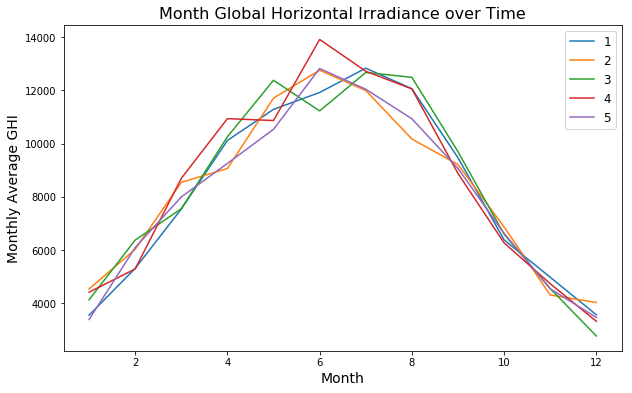

In [16]:
# Plot the Monthly Average GHI
plt.figure(figsize = (10,6))
plt.plot(d1.groupby('Month').mean()['GHI']*48, label = '1')
plt.plot(d2.groupby('Month').mean()['GHI']*48, label = '2')
plt.plot(d3.groupby('Month').mean()['GHI']*48, label = '3')
plt.plot(d4.groupby('Month').mean()['GHI']*48, label = '4')
plt.plot(d5.groupby('Month').mean()['GHI']*48, label = '5')
plt.title('Month Global Horizontal Irradiance over Time', {'fontsize': 16})
plt.xlabel('Month',{'fontsize': 14})
plt.ylabel('Monthly Average GHI',{'fontsize': 14})
plt.legend(loc='best', prop={'size': 12})
plt.show()

In [17]:
### Modeling ###

# Seasonal ARIMA model

ghi = daily_ghi(d1, 1) + daily_ghi(d2, 2) + daily_ghi(d3, 3) + daily_ghi(d4, 4) + daily_ghi(d5, 5) 
ghi = np.sqrt(ghi)

# Split the date into train and test set
train_percent = 0.7
train = ghi[:int(train_percent*len(ghi))]
test = ghi[int(train_percent*len(ghi)):]

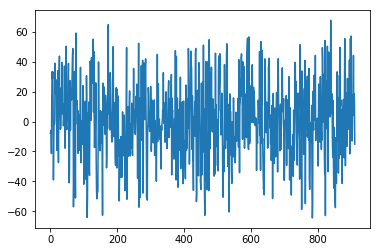

In [19]:
# Differencing

# Define the difference function
def diff(data, lag):
    return [data[i+lag] - ghi[i] for i in range(len(data)-lag)]

# Annual pattern shows S = 365
# Pick d and D
train_diff = diff(train,365)
plt.plot(train_diff)
plt.show() # d = 0, D = 1, s = 365.

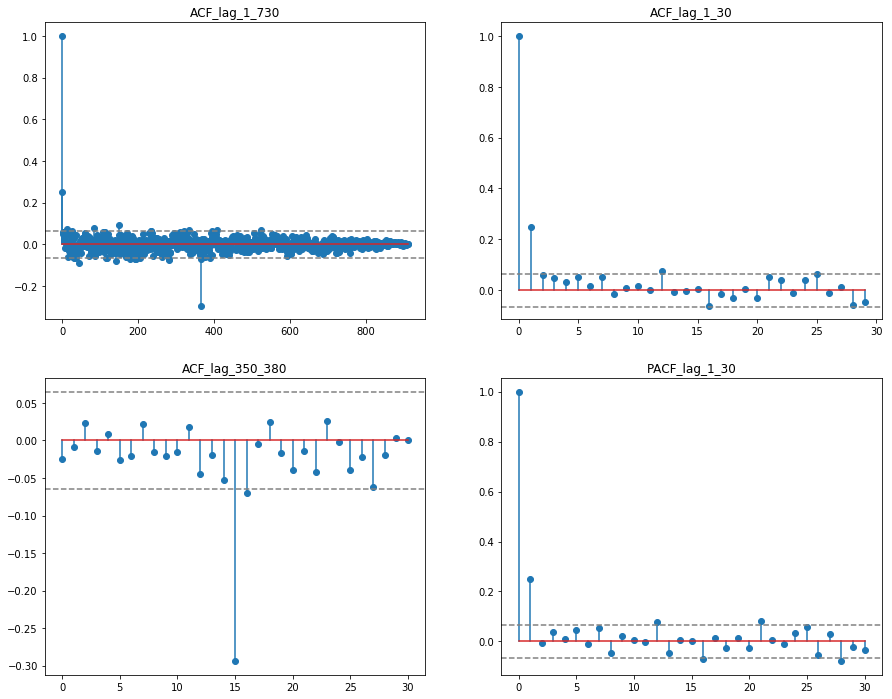

In [20]:
# Pick p, q, Q, P from ACF and PACF
train_acf = acf(train_diff, nlags = 1100)
train_pacf = pacf(train_diff, nlags = 30)

plt.figure(figsize = (15,12))
plt.subplot(221)
plt.stem(train_acf)
plt.title('ACF_lag_1_730')
plt.axhline(y = -1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.axhline(y = 1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')

plt.subplot(222)
plt.stem(train_acf[:30])
plt.axhline(y = -1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.axhline(y = 1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.title('ACF_lag_1_30')

plt.subplot(223)
plt.stem(train_acf[350:381])
plt.axhline(y = -1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.axhline(y = 1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.title('ACF_lag_350_380')

plt.subplot(224)
plt.stem(train_pacf)
plt.axhline(y = -1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.axhline(y = 1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.title('PACF_lag_1_30')

plt.show()

From the ACF, q = 1. From the PACF, p = 1.

Because the ACF at seasonal period 365 is negative, Q = 1 and P = 0. However, becasue of the limit of data, we can not fit the model with Q = 1.

So, candidate models are: SARIMA(1,0,1)(0,1,0)_365, SARIMA(0,0,1)(0,1,0)_365, SARIMA(1,0,0)(0,1,0)_365.

In [12]:
### Model Selection ###

# Define a function to compute Cross-Validated MSE
def cv_mse(train, order, seasonal_order = (0,0,0,0), cv_percent = 0.2, nfold = 5):
    l = len(train)
    splits = [round(l*(1-cv_percent + cv_percent/nfold*i)) for i in range(nfold)]
    mse = []
    for i in range(nfold):
        cv_train = train[:splits[i]]
        cv_test = train[splits[i]:]
        model = SARIMAX(cv_train, order = order, seasonal_order = seasonal_order, 
                        enforce_invertibility = False, enforce_stationarity = False)
        fit = model.fit()
        residuals = cv_test - fit.forecast(len(cv_test))
        mse.append(np.mean([x**2 for x in residuals]))
    return np.mean(mse)

# Compute the Cross-Validated MSE
mse1 = cv_mse(train, order = (0,0,1), seasonal_order = (0,1,0,365), nfold = 3)
mse2 = cv_mse(train, order = (1,0,0), seasonal_order = (0,1,0,365), nfold = 3)
mse3 = cv_mse(train, order = (1,0,1), seasonal_order = (0,1,0,365), nfold = 3)
(mse1, mse2, mse3)

# the  SARIMA(1,0,0)x(0,1,0,365) performs best

In [ ]:
# Fit the final model
model = SARIMAX(train, order = (1,0,0), seasonal_order = (0,1,0,365), 
                enforce_invertibility = False, enforce_stationarity = False)
fit = model.fit()

In [ ]:
# Diagnostic: check if the residuals look like a white noise
fit.plot_diagnostics(figsize = (12,12))
plt.show()

In [ ]:
# Make predictions on test set 
pred = fit.forecast(len(test))
mse_ts = np.mean([x**2 for x in pred - test])
mse_ts

Additionally, we can also try tree-based ensemble method to build a predictive model. Here, I use a Random Forest model to fit the data.

In [ ]:
### Random Forest ###

# Data preprocess 
def preprocess(d):
    temp = d.copy()
    year = int(temp.values[0][0])
    temp['Day_of_the_Year'] = [(datetime(int(x[0]),int(x[1]),int(x[2])) - 
                                datetime(year,1,1)).days+1 for x in temp.values]
    temp['Cloud Type'] = temp['Cloud Type'].astype('category')
    temp = pd.concat([temp, pd.get_dummies(temp['Cloud Type'], \
                                           prefix = 'Cloudtype_')], axis = 1)
    del temp['Cloud Type']
    return temp.groupby('Day_of_the_Year').mean()

df = pd.concat([preprocess(d1), preprocess(d2), preprocess(d3), preprocess(d4), preprocess(d5)])
df['GHI'] = [48*x for x in df['GHI']]

# remove useless features
cols = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'DHI', 'DNI']
for x in cols:
    del df[x]
del cols

# Deal with missing values
df['Cloudtype__10.0'][pd.isnull(df['Cloudtype__10.0'])] = 0

In [18]:
# Split train and test sets
X = df.copy()
del X['GHI']
Y = df['GHI']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 123)

In [ ]:
# Fit the model (Omit the parameter tuning part)
rf = RandomForestRegressor(n_estimators = 2000, max_depth = 4, max_features = 8, random_state = 42)
rf.fit(X_train, Y_train)

In [ ]:
# Feature Importance
temp = pd.DataFrame({'Variables':X.columns.values, \
                     'Importance' :rf.feature_importances_})
temp.sort_values('Importance', ascending = False)[:10]

In [ ]:
# Make prediction
pred = rf.predict(X_test)
mse_rf = np.mean([x**2 for x in np.sqrt(pred) - np.sqrt(Y_test)])
mse_rf